# <center>Polynomial Regression from Scratch:<br> A Comprehensive Guide  </center>

Welcome to this **step-by-step notebook** on implementing **Polynomial Regression 
from scratch**! 🚀Polynomial regression is a powerful extension of linear regression, 
enabling us to model **non-linear relationships** between input features and output targets. 
While popular libraries like Scikit-learn simplify its implementation, building it from scratch 
provides deeper insights into its inner workings and optimizations.

---

### 🌐 **Follow Me on Social Media:**  

- [![LinkedIn](https://img.shields.io/badge/LinkedIn-Connect-blue?style=flat&logo=linkedin)](https://linkedin.com/in/codewithdark)  
- [![GitHub](https://img.shields.io/badge/GitHub-Follow-black?style=flat&logo=github)](https://github.com/codewithdark-git)  
- [![Kaggle](https://img.shields.io/badge/Kaggle-Follow-blue?style=flat&logo=kaggle)](https://kaggle.com/codewithdark)
- [![See Notebook](https://img.shields.io/badge/Kaggle-View%20Notebooks-blue?style=flat&logo=kaggle)](https://www.kaggle.com/code/codewithdark/polynomial-regression-from-scratch)
- [![See Blog Post](https://img.shields.io/badge/Read-Blog%20Post-blue?style=flat&logo=readme)](https://gist.github.com/codewithdark-git/755c61a16a6ded2e855c162169bf63a4)

---

### What You'll Learn in This Notebook:
1. **Mathematical Foundation**: Understand the key equations and concepts behind polynomial regression.  
2. **Data Generation & Visualization**: Create and explore synthetic non-linear datasets.  
3. **Custom Implementation**: Build a **Custom Polynomial Regression Estimator** with advanced features like:  
   - Polynomial transformations  
   - Feature scaling  
   - Interaction terms  
   - Feature selection  
4. **Model Comparisons**: Compare our custom implementation with Scikit-learn's pipeline for:  
   - R² Scores  
   - Training Time  
   - Prediction Accuracy  
5. **Gradient Descent**: Explore how optimization works through gradient-based updates.  
6. **Performance Metrics and Visualizations**: Analyze and visualize results with interactive plots.  

By the end of this notebook, you'll have a deeper understanding of both **theory** and **practical implementation**, empowering you to tackle real-world regression problems with confidence.  

Let’s get started! 🚀  


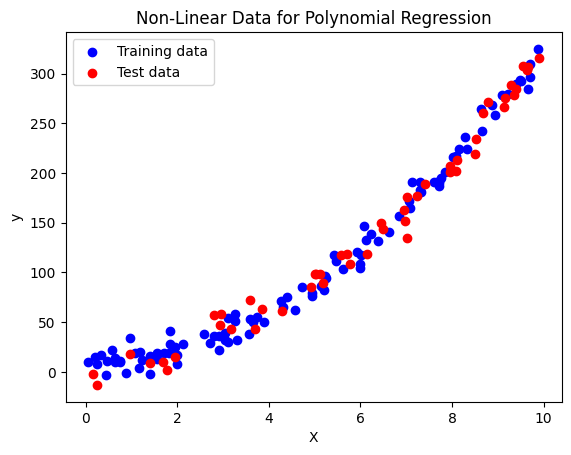

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# Create non-linear data (quadratic)
np.random.seed(42)  # For reproducibility
X_train = np.random.rand(100, 1) * 10  # 100 random values between 0 and 10
y_train = 3 * X_train**2 + 2 * X_train + 5 + np.random.randn(100, 1) * 10  # Quadratic equation with noise

X_test = np.random.rand(50, 1) * 10  # 50 random values for testing
y_test = 3 * X_test**2 + 2 * X_test + 5 + np.random.randn(50, 1) * 10  # Same quadratic equation with noise

# Plot the data
plt.scatter(X_train, y_train, color='blue', label='Training data')
plt.scatter(X_test, y_test, color='red', label='Test data')
plt.title('Non-Linear Data for Polynomial Regression')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.savefig('images/plot_data.png')
plt.show()


# Now with Linear Regression


## Build-In Linear Regression VS Build-In Polynomial Regression

In [61]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import time

# Assuming X_train, y_train, X_test, y_test are already defined
model_sklearn = make_pipeline(PolynomialFeatures(degree=2, interaction_only=True), LinearRegression())

# Measure training time
start_time = time.time()
model_sklearn.fit(X_train, y_train)
pred = model_sklearn.predict(X_test)

# Calculate R^2 score
score_sklearn_train = model_sklearn.score(X_test, y_test)
print(f"Sklearn Model Training R^2 Score: {score_sklearn_train:.4f}")

end_time = time.time()
time_sklearn = end_time - start_time
print(f"Time taken for training and prediction: {time_sklearn:.4f} seconds")


Sklearn Model Training R^2 Score: 0.9349
Time taken for training and prediction: 0.1115 seconds


## Build-in linear Regression VS Custom Polynomial Regressor


In [62]:
import numpy as np
from itertools import combinations, combinations_with_replacement
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, RegressorMixin

class CustomPolynomialEstimator:
    def __init__(self, degree=2, include_bias=True, include_interactions=True, 
                 feature_selection_threshold=0.01, use_scaling=True):
        self.degree = degree
        self.include_bias = include_bias
        self.include_interactions = include_interactions
        self.feature_selection_threshold = feature_selection_threshold
        self.use_scaling = use_scaling
        self.scaler = StandardScaler() if use_scaling else None
        self.feature_importances_ = None
        
    def _combinations(self, n_features, degree):
        """Generate combinations of features indices for polynomial terms"""
        return combinations_with_replacement(range(n_features), degree)
    
    def fit(self, X, y=None):
        # Scale the input features if requested
        if self.use_scaling:
            X = self.scaler.fit_transform(X)
        
        n_samples, n_features = X.shape
        self.n_features_ = n_features
        
        # Store mean and variance of features for feature importance
        self.feature_means_ = np.mean(X, axis=0)
        self.feature_vars_ = np.var(X, axis=0)
        
        return self
    
    def _calculate_feature_importance(self, X):
        """Calculate feature importance based on variance and correlation"""
        if y is not None:
            correlations = np.array([np.corrcoef(X[:, i], y)[0, 1] for i in range(X.shape[1])])
            return np.abs(correlations) * self.feature_vars_
        return self.feature_vars_
    
    def transform(self, X):
        if self.use_scaling:
            X = self.scaler.transform(X)
            
        n_samples, n_features = X.shape
        combo_list = []
        
        # Add bias term
        if self.include_bias:
            combo_list.append(np.ones(n_samples).reshape(-1, 1))
        
        # Add original features
        combo_list.append(X)
        
        # Add polynomial terms with optimized computation
        for d in range(2, self.degree + 1):
            poly_terms = []
            for combo in self._combinations(n_features, d):
                # Vectorized computation of polynomial terms
                term = np.prod(X[:, combo], axis=1)
                poly_terms.append(term.reshape(-1, 1))
            
            if poly_terms:
                poly_features = np.hstack(poly_terms)
                # Feature selection based on variance
                variances = np.var(poly_features, axis=0)
                mask = variances > self.feature_selection_threshold
                if np.any(mask):
                    combo_list.append(poly_features[:, mask])
        
        # Add interaction terms if specified
        if self.include_interactions:
            for d in range(2, min(self.degree + 1, n_features + 1)):
                interaction_terms = []
                for combo in combinations(range(n_features), d):
                    if len(set(combo)) == d:  # Only pure interactions
                        term = np.prod(X[:, combo], axis=1)
                        interaction_terms.append(term.reshape(-1, 1))
                
                if interaction_terms:
                    interaction_features = np.hstack(interaction_terms)
                    # Feature selection for interaction terms
                    variances = np.var(interaction_features, axis=0)
                    mask = variances > self.feature_selection_threshold
                    if np.any(mask):
                        combo_list.append(interaction_features[:, mask])
        
        # Concatenate all terms
        X_poly = np.hstack(combo_list)
        
        return X_poly
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [63]:

start_time = time.time()
model_custom = make_pipeline(CustomPolynomialEstimator(degree=2, include_interactions=True), LinearRegression())
model_custom.fit(X_train, y_train)

pred_custom = model_custom.predict(X_test)

# Calculate R^2 score
score_custom_train = model_custom.score(X_test, y_test)
print(f"Sklearn Model Training R^2 Score: {score_custom_train:.4f}")

end_time = time.time()
time_custom = end_time - start_time
print(f"Time taken for training and prediction: {time_custom:.4f} seconds")

Sklearn Model Training R^2 Score: 0.9865
Time taken for training and prediction: 0.0216 seconds


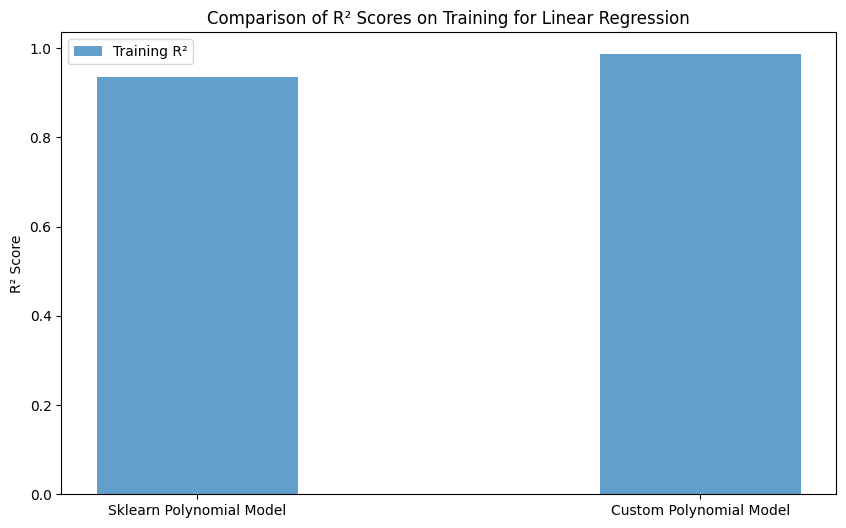

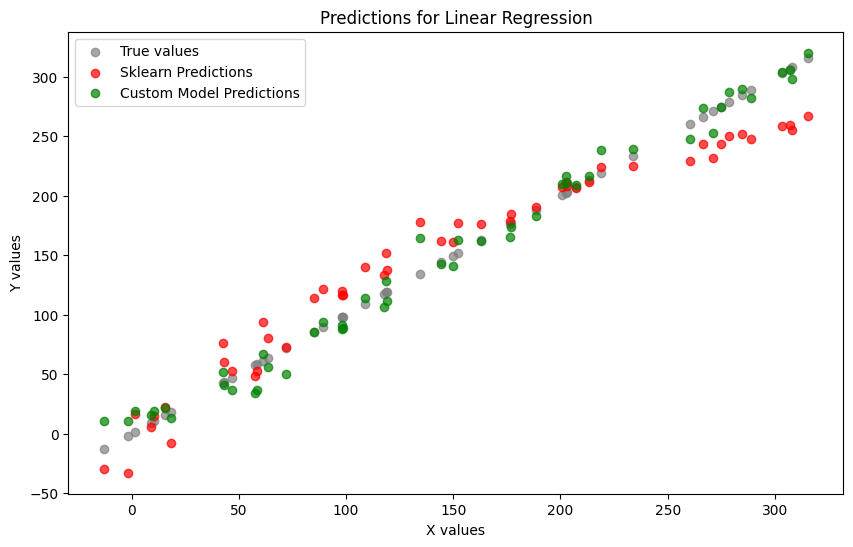

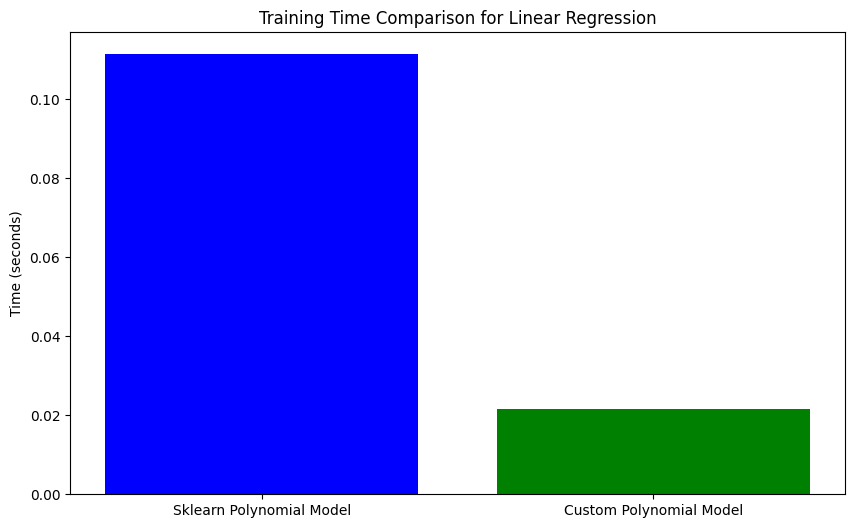

In [64]:
import matplotlib.pyplot as plt

# Visualize results

# 1. Training vs Test R^2 scores
plt.figure(figsize=(10, 6))
models = ['Sklearn Polynomial Model', 'Custom Polynomial Model']
train_scores = [score_sklearn_train, score_custom_train]
plt.bar(models, train_scores, width=0.4, label='Training R²', align='center', alpha=0.7)
plt.ylabel('R² Score')
plt.title('Comparison of R² Scores on Training for Linear Regression')
plt.legend()

plt.savefig('images/R2_Scores_Comparison.png')
plt.show()


# 3. Predictions vs Actual values (comparison plot)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test, color='gray', label='True values', alpha=0.7)
plt.scatter(y_test, pred, color='red', label='Sklearn Predictions', alpha=0.7)
plt.scatter(y_test, pred_custom, color='green', label='Custom Model Predictions', alpha=0.7)
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('Predictions for Linear Regression')
plt.legend()
plt.savefig('images/predictions_Comparison.png')
plt.show()

# 4. Training time comparison
plt.figure(figsize=(10, 6))
plt.bar(models, [time_sklearn, time_custom], color=['blue', 'green'])
plt.ylabel('Time (seconds)')
plt.title('Training Time Comparison for Linear Regression')
plt.savefig('images/time_Comparison.png')
plt.show()

# Now with Gradient Descent






## Build-In Gradient Descent VS Build-In Polynomial Regressor


In [66]:
from sklearn.linear_model import SGDRegressor


# Assuming X_train, y_train, X_test, y_test are already defined

sgd = make_pipeline(PolynomialFeatures(degree=2, interaction_only=True), SGDRegressor())

# Measure training time

start_time = time.time()
sgd.fit(X_train, y_train)
pred_sgd = sgd.predict(X_test)

# Calculate R^2 score

score_sgd_train = sgd.score(X_test, y_test)
print(f"SGD Model Training R^2 Score: {score_sgd_train:.4f}")

end_time = time.time()
time_sgd = end_time - start_time
print(f"Time taken for training and prediction: {time_sgd:.4f} seconds")

SGD Model Training R^2 Score: 0.9344
Time taken for training and prediction: 0.0512 seconds


c:\Users\Dark_Coder\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Build-In Gradient Descent VS Custom Polynomial Regressor

In [67]:
custom_sgd = make_pipeline(CustomPolynomialEstimator(degree=2, include_interactions=True), SGDRegressor())

# Measure training time

start_time = time.time()
custom_sgd.fit(X_train, y_train)
pred_custom_sgd = custom_sgd.predict(X_test)

# Calculate R^2 score

score_custom_sgd_train = custom_sgd.score(X_test, y_test)
print(f"Custom SGD Model Training R^2 Score: {score_custom_sgd_train:.4f}")

end_time = time.time()
time_custom_sgd = end_time - start_time

print(f"Time taken for training and prediction: {time_custom_sgd:.4f} seconds")

Custom SGD Model Training R^2 Score: 0.9865
Time taken for training and prediction: 0.0444 seconds


c:\Users\Dark_Coder\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Visualize results


### 1. Training vs Test R^2 scores


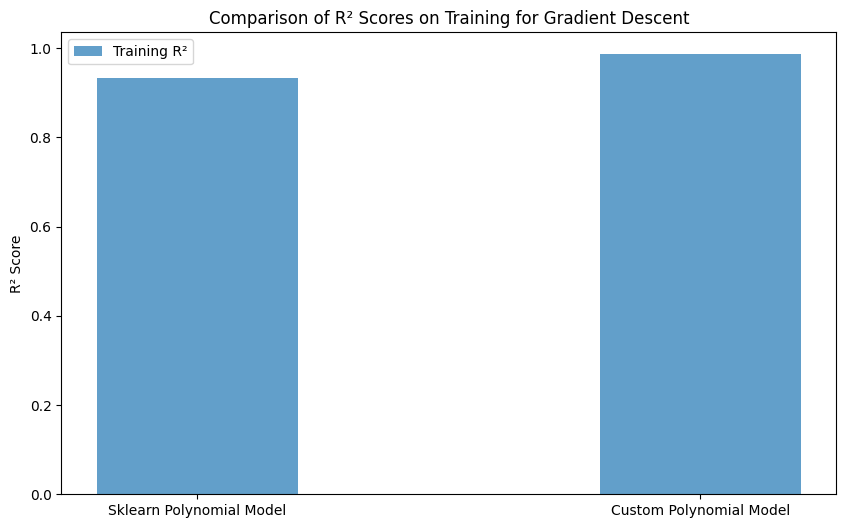

In [68]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
models = ['Sklearn Polynomial Model', 'Custom Polynomial Model']
train_scores = [score_sgd_train, score_custom_sgd_train]
plt.bar(models, train_scores, width=0.4, label='Training R²', align='center', alpha=0.7)
plt.ylabel('R² Score')
plt.title('Comparison of R² Scores on Training for Gradient Descent')
plt.legend()
plt.savefig('images/R2_Scores_Comparison_for_Gradient_Descent.png')
plt.show()

### 2. Predictions vs Actual values (comparison plot)

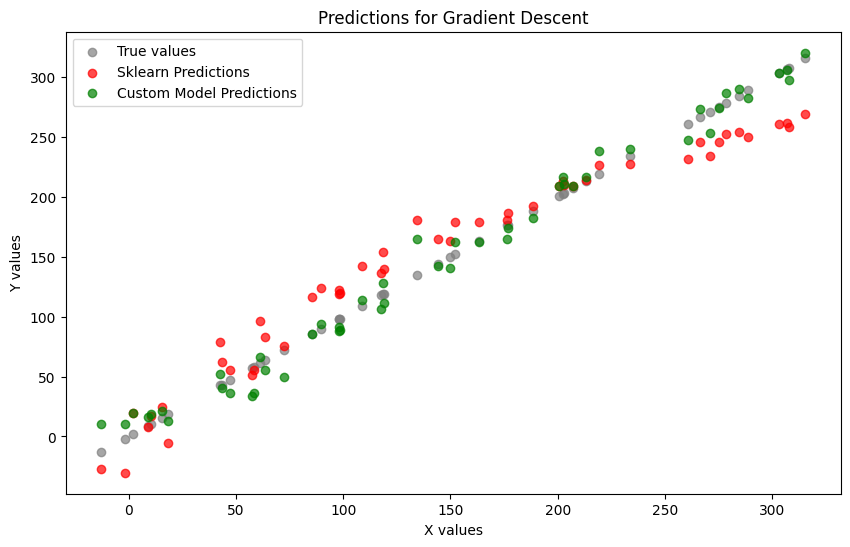

In [69]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test, color='gray', label='True values', alpha=0.7)
plt.scatter(y_test, pred_sgd, color='red', label='Sklearn Predictions', alpha=0.7)
plt.scatter(y_test, pred_custom_sgd, color='green', label='Custom Model Predictions', alpha=0.7)
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('Predictions for Gradient Descent')
plt.legend()
plt.savefig('images/predictions_Comparison_for_Gradient_Descent.png')
plt.show()



### 3. Training time comparison

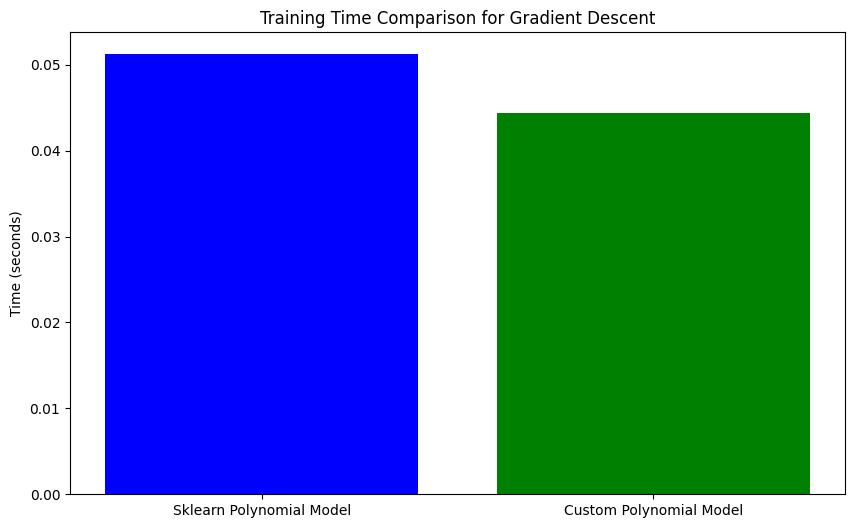

In [70]:

plt.figure(figsize=(10, 6))
plt.bar(models, [time_sgd, time_custom_sgd], color=['blue', 'green'])
plt.ylabel('Time (seconds)')
plt.title('Training Time Comparison for Gradient Descent')
plt.savefig('images/time_Comparison_for_Gradient_Descent.png')
plt.show()

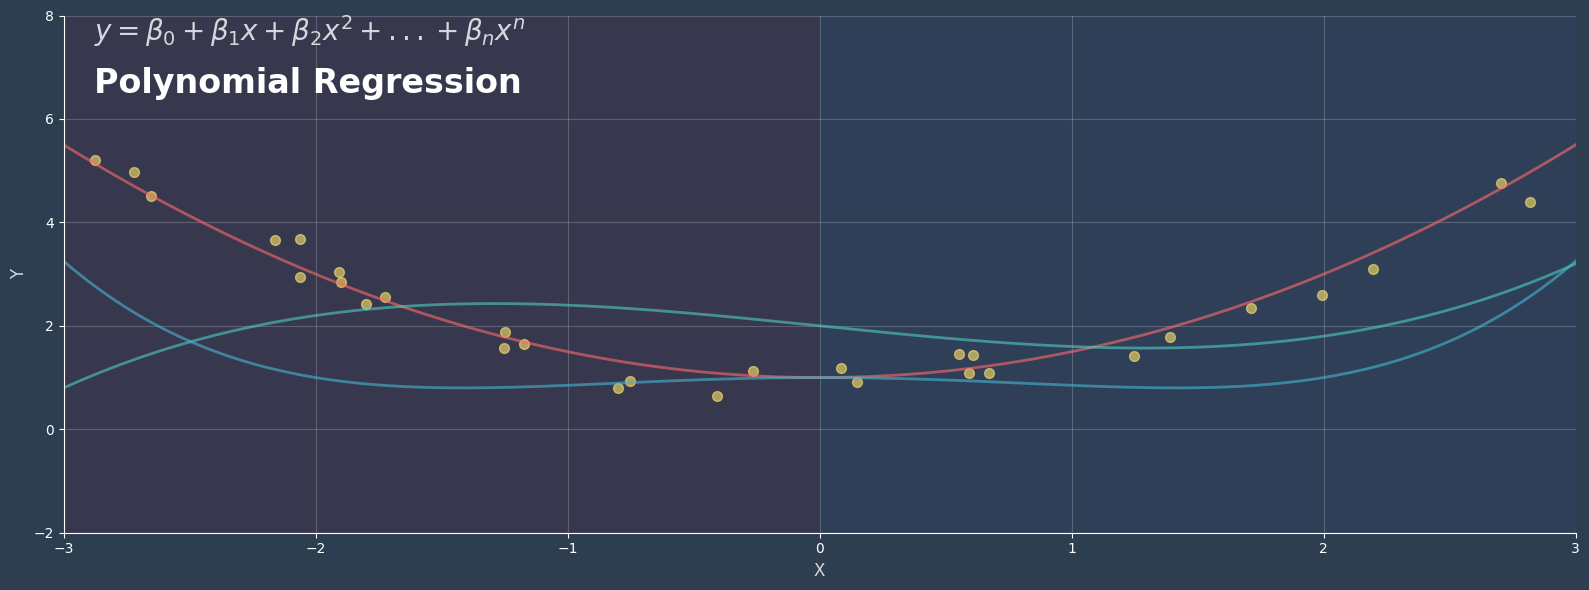

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

def create_header_image():
    # Set style and figure size
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(16, 6))
    
    # Create main plot area
    ax = plt.subplot(111)
    
    # Generate data for polynomial curves
    x = np.linspace(-3, 3, 200)
    
    # Create multiple polynomial curves
    y1 = 0.5*x**2 + 1  # Quadratic
    y2 = 0.1*x**3 - 0.5*x + 2  # Cubic
    y3 = 0.05*x**4 - 0.2*x**2 + 1  # Quartic
    
    # Add some noise to make it look more realistic
    np.random.seed(42)
    scatter_x = np.random.uniform(-3, 3, 30)
    scatter_y = 0.5*scatter_x**2 + 1 + np.random.normal(0, 0.3, 30)
    
    # Plot curves with gradient colors
    ax.plot(x, y1, color='#FF6B6B', alpha=0.6, linewidth=2, label='Quadratic')
    ax.plot(x, y2, color='#4ECDC4', alpha=0.6, linewidth=2, label='Cubic')
    ax.plot(x, y3, color='#45B7D1', alpha=0.6, linewidth=2, label='Quartic')
    
    # Add scatter points
    ax.scatter(scatter_x, scatter_y, color='#FFE66D', alpha=0.6, s=50)
    
    # Add mathematical formula
    formula = r'$y = \beta_0 + \beta_1x + \beta_2x^2 + ... + \beta_nx^n$'
    plt.text(0.02, 0.95, formula, transform=ax.transAxes, 
             fontsize=20, color='white', alpha=0.8)
    
    # Add title
    plt.text(0.02, 0.85, 'Polynomial Regression', transform=ax.transAxes,
             fontsize=24, color='white', fontweight='bold')
    
    # Customize the plot
    ax.set_xlabel('X', fontsize=12, color='white', alpha=0.8)
    ax.set_ylabel('Y', fontsize=12, color='white', alpha=0.8)
    ax.grid(True, alpha=0.2)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Set background color
    fig.patch.set_facecolor('#2C3E50')
    ax.set_facecolor('#2C3E50')
    
    # Add subtle gradient background
    gradient = np.linspace(0, 1, 2)
    gradient = np.vstack((gradient, gradient))
    ax.imshow(gradient, extent=[-3, 3, -2, 8], 
              cmap='Spectral', alpha=0.1, aspect='auto')
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig('images/header.png', dpi=300, bbox_inches='tight', 
                facecolor='#2C3E50', edgecolor='none')
    plt.show()
    plt.close()

# Create directory if it doesn't exist
import os
if not os.path.exists('images'):
    os.makedirs('images')

# Generate the header image
create_header_image()

In [55]:
from matplotlib.animation import FuncAnimation, PillowWriter
def create_complex_animated_header():
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(16, 6))
    ax = plt.subplot(111)
    
    # Generate data
    np.random.seed(42)
    x = np.linspace(-3, 3, 200)
    scatter_x = np.random.uniform(-3, 3, 30)
    true_y = 0.5*scatter_x**2 + 1
    scatter_y = true_y + np.random.normal(0, 0.3, 30)
    
    # Initialize plots
    scatter = ax.scatter(scatter_x, scatter_y, color='#FFE66D', alpha=0.6, s=50)
    lines = [ax.plot([], [], alpha=0.8, linewidth=3)[0] for _ in range(3)]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    for line, color in zip(lines, colors):
        line.set_color(color)
    
    # Setup plot
    ax.set_xlim(-3.5, 3.5)
    ax.set_ylim(-2, 8)
    ax.grid(True, alpha=0.2)
    fig.patch.set_facecolor('#2C3E50')
    ax.set_facecolor('#2C3E50')
    
    def init():
        for line in lines:
            line.set_data([], [])
        return lines
    
    def animate(frame):
        t = frame / 50
        
        # Different polynomial degrees
        y1 = t*(0.5*x**2 + 1)  # Quadratic
        y2 = t*(0.1*x**3 - 0.5*x + 2)  # Cubic
        y3 = t*(0.05*x**4 - 0.2*x**2 + 1)  # Quartic
        
        # Update lines
        lines[0].set_data(x, y1)
        lines[1].set_data(x, y2)
        lines[2].set_data(x, y3)
        
        # Update formula
        plt.text(0.02, 0.95, 
                f'Polynomial Degrees: 2, 3, 4', 
                transform=ax.transAxes,
                fontsize=20, color='white', alpha=0.8)
        
        return lines
    
    anim = FuncAnimation(fig, animate, init_func=init,
                        frames=100, interval=50, blit=True)
    
    writer = PillowWriter(fps=30)
    anim.save('images/header_animated_complex.gif', writer=writer)
    plt.close()


create_complex_animated_header()